In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.insert(0, '../fem')
from GRF import GRF

sys.path.insert(0, '../ml')
from VarMiON import VarMiON
from modelloader import loadmodelfromlabel

In [2]:
simparams = {'d': 2,
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

p_theta = {'l': 0.4,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_f = {'l': 0.2,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_eta = {'l': 0.3,
        'lowerbound': -1,
        'upperbound': 1}

trainingdataparams = {'inputdata': 'grf',
                   'theta': p_theta,
                   'f': p_f,
                   'eta': p_eta,
                   'N_sensornodes': 144,
                   'N_outputnodes': 268,
                   'N_samples': 100}

params = {}
params['trainingdataparams'] = trainingdataparams
params['simparams'] = simparams

In [3]:
GRF = GRF(**simparams, **trainingdataparams, **trainingdataparams['f'])

In [4]:
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T

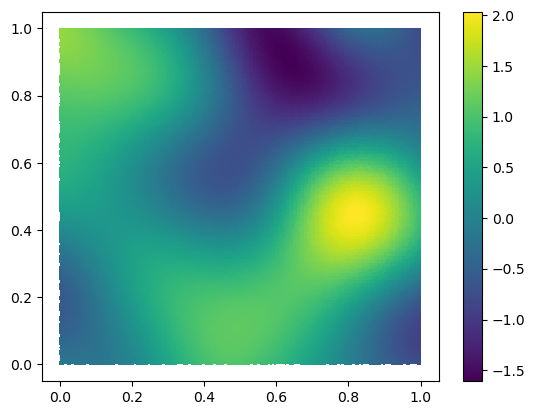

In [5]:
func = GRF.RBFint(sample=0)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
func(x_i).shape
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i)[0])
plt.colorbar()

In [6]:
R90 = np.array([[0,-1],[1,0]])
R180 = R90@R90
R270 = R180@R90

In [7]:
# GRF.x_grid = GRF.x_grid - 1/2
GRF.x_grid = np.einsum('ij,gj->gi', R90, GRF.x_grid - 1/2) + 1/2
# GRF.x_grid = GRF.x_grid + 1/2

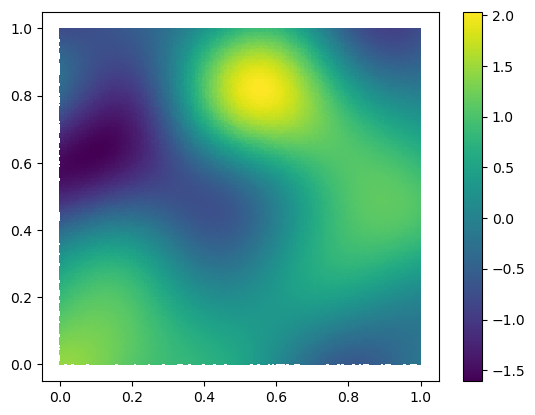

In [8]:
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i)[0])
plt.colorbar()
plt.show()

In [9]:
GRF.x_grid = np.einsum('ij,gj->gi', R270, GRF.x_grid - 1/2) + 1/2

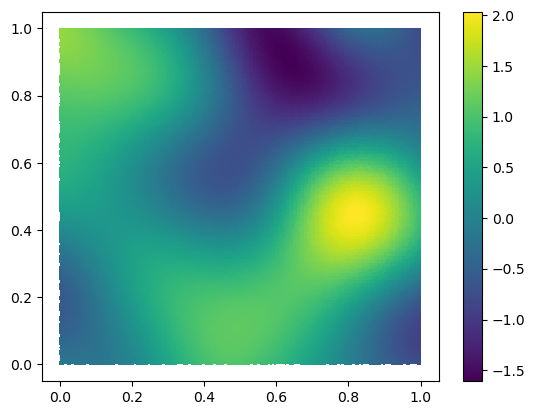

In [10]:
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i)[0])
plt.colorbar()

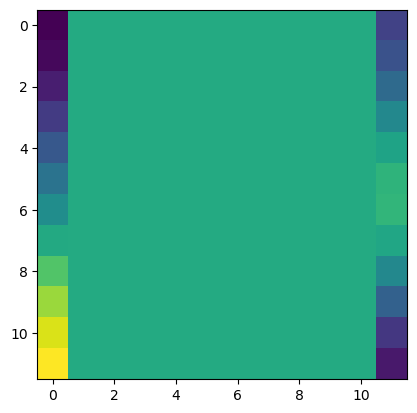

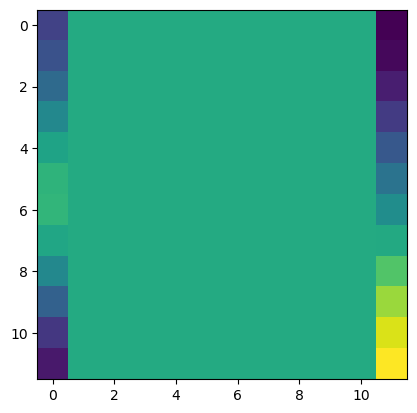

In [11]:
N = np.load('../../../trainingdata/grf/train/N.npy')
plt.imshow(N[0])
plt.show()
plt.imshow(torch.tensor(N[0]).fliplr().detach().numpy())

In [12]:
Theta = torch.rand((100,12,12),dtype=torch.double)
F = torch.rand((100,12,12),dtype=torch.double)
N = torch.rand((100,12,12),dtype=torch.double)
x = torch.rand((100,268,2),dtype=torch.double)
u = torch.rand((100,268),dtype=torch.double)

In [22]:
from VarMiON import VarMiON

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'grf'
map_location = 'cpu'
symgroupavg = loadmodelfromlabel(model=VarMiON, label='symgroupavg', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

In [23]:
symgroupavg.symgroupavg_forward(Theta, F, N, x)

tensor([[1.6236, 2.1512, 1.2574,  ..., 1.8367, 1.6904, 1.0854],
        [1.0770, 1.2421, 1.1604,  ..., 1.0616, 1.5225, 1.2132],
        [1.4643, 1.4675, 1.2537,  ..., 1.3735, 0.6682, 1.2726],
        ...,
        [1.9914, 2.7040, 2.6897,  ..., 1.9384, 3.1584, 2.5547],
        [1.6838, 1.3328, 1.2829,  ..., 1.4942, 1.6415, 1.6530],
        [1.3493, 0.9660, 1.5609,  ..., 1.5230, 1.0042, 1.8281]],
       grad_fn=<DivBackward0>)

In [5]:
R = torch.tensor([[0,-1],[1,0]], dtype=model.hparams['dtype'])
R=R@R@R
M = torch.tensor([[1,0],[0,-1]], dtype=model.hparams['dtype'])
I = torch.tensor([[1,0],[0,1]], dtype=model.hparams['dtype'])
D8 = [I, R, R@R, R@R@R, M, R@M, R@R@M, R@R@R@M]

In [6]:
Theta_D8 = [Theta, 
            Theta.rot90(), 
            Theta.rot90().rot90(), 
            Theta.rot90().rot90().rot90(),
            Theta.fliplr(),
            Theta.fliplr().rot90(),
            Theta.fliplr().rot90().rot90(), 
            Theta.fliplr().rot90().rot90().rot90()]
            
F_D8 = [F, 
            F.rot90(), 
            F.rot90().rot90(), 
            F.rot90().rot90().rot90(),
            F.fliplr(),
            F.fliplr().rot90(),
            F.fliplr().rot90().rot90(), 
            F.fliplr().rot90().rot90().rot90()]

In [7]:
def expand_D8(A):
    return [A, 
            A.rot90(dims=(-1,-2)), 
            A.rot90(dims=(-1,-2)).rot90(dims=(-1,-2)), 
            A.rot90(dims=(-1,-2)).rot90(dims=(-1,-2)).rot90(dims=(-1,-2)),
            A.fliplr(),
            A.fliplr().rot90(dims=(-1,-2)),
            A.fliplr().rot90(dims=(-1,-2)).rot90(dims=(-1,-2)), 
            A.fliplr().rot90(dims=(-1,-2)).rot90(dims=(-1,-2)).rot90(dims=(-1,-2))]

In [8]:
Theta_D8 = expand_D8(Theta)
F_D8 = expand_D8(F)
N_D8 = expand_D8(N)
u_hat = torch.zeros(u.shape)
for alpha in range(len(D8)):
    model.Trunk.mus = torch.nn.Parameter(torch.einsum('ij,gj->gi', torch.linalg.inv(D8[alpha]), model.Trunk.mus - 1/2) + 1/2)
    u_hat += model.forward(Theta_D8[alpha], F_D8[alpha], N_D8[alpha], x)
    model.Trunk.mus = torch.nn.Parameter(torch.einsum('ij,gj->gi', D8[alpha], model.Trunk.mus - 1/2) + 1/2)
u_hat = u_hat/len(D8)

In [10]:
model.symgroupavg_forward(Theta, F, N, x)

0
1
2
3
4
5
6
7


tensor([[-0.6916, -1.0484, -1.5651,  ..., -1.4364, -1.5739, -0.1793],
        [-0.9024,  0.5105, -0.3692,  ..., -1.2884,  1.0552, -1.0073],
        [-2.3677, -4.1780, -2.7496,  ..., -3.8685, -2.8914, -1.5022],
        ...,
        [-0.7492,  0.3420, -0.8772,  ...,  0.3892, -0.6830,  0.2349],
        [-1.7916, -1.9668, -2.3396,  ..., -2.0829, -2.8659, -3.0883],
        [-0.4815, -0.1059, -0.9238,  ..., -1.0848, -1.1531, -1.0128]],
       grad_fn=<DivBackward0>)